In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from functions import *

from scipy.optimize import minimize
from multiprocess import Pool

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('mcycle.csv')

In [3]:
df.columns = ['x','y']

In [4]:
df = df.sort_values(by=['y'])

In [5]:
y = df.y
X = df.x

#b0=1, b1=1 90 % obs 
#b0=0, b=1 85 %
b0 = 0
b1 = 4

In [6]:
df.min()

x      2.4
y   -134.0
dtype: float64

In [7]:
n = len(df)
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

In [8]:
sum(omega)/len(df)

0.7218045112781954

In [9]:
df['omega'] = omega

In [10]:
df_cc = df[df.omega==1]

In [11]:
df_cc.min()

x          2.4
y       -134.0
omega      1.0
dtype: float64

In [12]:
model = KernelReg(endog=[df.y],exog=[df.x],reg_type='ll',var_type='c', bw='cv_ls')


In [13]:
model = KernelReg(endog=[df.y],exog=[df.x],reg_type='ll',var_type='c', bw='cv_ls')

model_cc = KernelReg(endog=[df_cc.y],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')


In [14]:
model.bw

array([1.47580185])

In [15]:
def r_parallel(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return (df.omega[j]/pi(df.y[j],b0,b1))*(df.y[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [16]:
%%time
# r_parallel(0.1)
h_ipw = minimize(r_parallel, 0.7).x

CPU times: user 3.27 s, sys: 649 ms, total: 3.92 s
Wall time: 4.03 s


In [17]:
h_ipw[0]

1.017689533617527

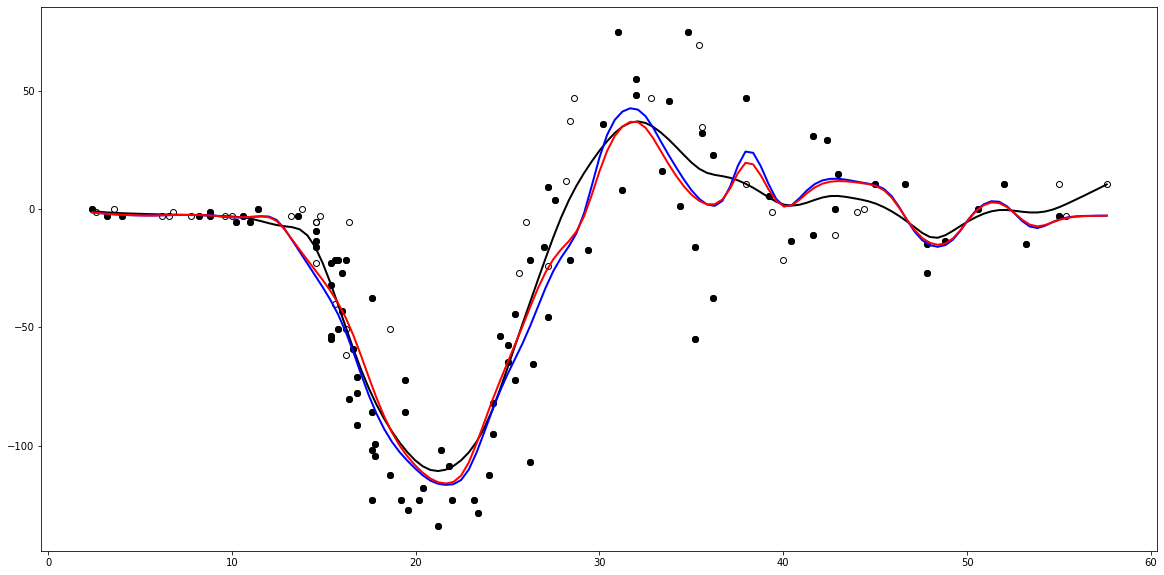

In [18]:
fig, ax = plt.subplots(1, 1,figsize=(20, 10))

plt.plot(df['x'],df['y'],'o',mfc='none',color='black')
plt.plot(df_cc['x'],df_cc['y'],'o',color='black')


#Full model 
ax.plot(np.linspace(2.4, 57.6, n),model.fit(np.linspace(2.4, 57.6, n))[0] ,color= 'black', lw=2)

#CC estimator 
ax.plot(np.linspace(2.4, 57.6, n),model_cc.fit(np.linspace(2.4, 57.6, n))[0] ,color= 'blue', lw=2)

#IPW estimator 
ax.plot(np.linspace(2.4, 57.6, n),[nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(2.4, 57.6, n)],color= 'red', lw=2)



In [19]:
df['res_sqr'] = (df.y -  model.fit(df.x)[0])**2

df_cc['res_sqr'] = (df_cc.y - model_cc.fit(df_cc.x)[0])**2

<ipython-input-19-db51aa9c97c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['res_sqr'] = (df_cc.y - model_cc.fit(df_cc.x)[0])**2


In [20]:
#Full residual-based
model_var = KernelReg(endog=[df.res_sqr],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')

model_var_cc = KernelReg(endog=[df_cc.res_sqr],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')

#Direct method 
h_fix = 0.8

model_dir_vn = KernelReg(endog=[(df.y)**2],exog=[df.x],reg_type='lc',var_type='c', bw='{h}') 
model_dir_mn = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='{h}') 

#Differences 

#Residual

In [21]:
df_diff = df[['x','y']]

In [22]:
df_diff['y'] =df_diff[['y']].diff().apply(lambda y:(y**2)/2)

<ipython-input-22-369addfdb23c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['y'] =df_diff[['y']].diff().apply(lambda y:(y**2)/2)


In [23]:
model_diff = KernelReg(endog=[df_diff.y],exog=[df_diff.x],reg_type='ll',var_type='c', bw='{h}') 

In [24]:
model_dir_mn = KernelReg(endog=[df_diff.y],exog=[df_diff.x],reg_type='lc',var_type='c', bw='{h}') 

In [25]:
def r_parallel_res(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.res_sqr[j]*nw_mis(h,df.x[j],df1.x,df1.res_sqr,pi(df1.y,b0,b1),df1.omega)
        return (df.omega[j]/pi(df.res_sqr[j],b0,b1))*(df.res_sqr[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [26]:
%%time
# r_parallel(0.1)
h_ipw_var = minimize(r_parallel, 0.1).x

CPU times: user 3.77 s, sys: 742 ms, total: 4.51 s
Wall time: 4.69 s


In [27]:
h_ipw_var

array([1.01768955])

<ipython-input-33-17da20a191b1>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-g" (-> color='g'). The keyword argument will take precedence.
  ax.plot(np.linspace(2.4, 57.6, n),[sigma_mis_res(h_ipw_var[0],t,X,df.res_sqr,pi(y,b0,b1),omega)**2 for t in np.linspace(2.4, 57.6, n)],'-g',color= 'red', lw=2)


(0.0, 2000.0)

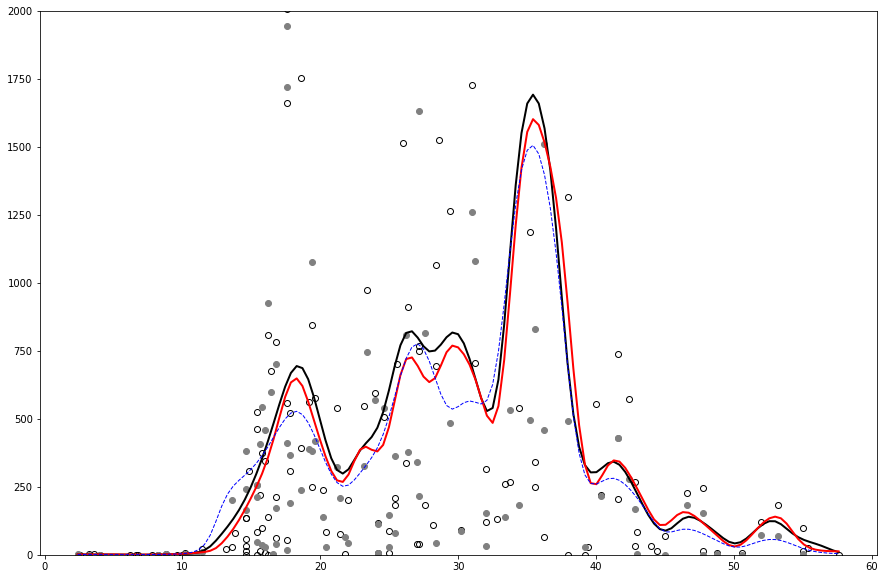

In [33]:
fig, ax = plt.subplots(1, 1,figsize=(15, 10))

plt.plot(df['x'],df['res_sqr'],'o',mfc='none',color='black')

plt.plot(df_cc['x'],df_cc['res_sqr'],'o',color='grey')

#Full model 
ax.plot(np.linspace(2.4, 57.6, n),model_var.fit(np.linspace(2.4, 57.6, n))[0] ,color= 'black', lw=2)

#IPW
ax.plot(np.linspace(2.4, 57.6, n),[sigma_mis_res(h_ipw_var[0],t,X,df.res_sqr,pi(y,b0,b1),omega)**2 for t in np.linspace(2.4, 57.6, n)],'-g',color= 'red', lw=2)

#Complete-case 
ax.plot(np.linspace(2.4, 57.6, n),model_var_cc.fit(np.linspace(2.4, 57.6, n))[0] ,color= 'blue', lw=1,linestyle='dashed')

ax.set_ylim(0,2000)

In [35]:
df.res_sqr.mean()

459.8609085228205